# Some hightlights of my suggested approach

### Feature extraction
The current set of features (with 15 features) is rather small. I suggest that we use more features. Of course increasing the number of features while having a small training set (just about 50 data points) will increase the likelihood of overfitting. When this happens we can apply regularization methods like L1, L2 or dropout to solve the overfitting problem.

* The first set of features we can try is from `dc.feat.RDKitDescriptors` which generates 200 features. They describe chemical and physical properties of a molecule. I beleive that the 15 features you generated from **mayachemtools** is just a subset of the one generated from `dc.feat.RDKitDescriptors`. We can use this set of feature with both shallow and deep learning.

* The next step to try is to use molecular fingerprints from `DeepChem`. I think the two most commonly used approaches are "Extended Connectivity Fingerprint" (or ECFP) and `GaphConv`. `GaphConv` is state of the art (https://arxiv.org/abs/1509.09292). However it is an embedding approach and we have to use it as the top layer in a neural network model. If we want to use `GaphConv` fingerprint for shallow models such as Random Forest or XGBoost, we have to train a unsuppervised embedding model first.


### Models
* First we should try *Linear Regression* and *Logistic Regression* as baseline models for regression and classification problems. Then we can use more complex model such as *Random Forest*, *XGBoost* and deeplearning models. From my experience, `XGBoost` works extremly well for classification problems, so it is worth trying it.


### Training and model selection
* Since our training set is rather small, we should not split it into three sets (train, validation and test). Instead we should split into two: train and test. Since we don't have a validation set, we can use cross-validation to optimize the hyperparameters and select the best overall model using the test set. After having the best model, we retrain using all the data before doing prediction on the ZINC dataset.

* To optimize the hyperparameter, we should use the library `hyperopt` which is the most popular Bayesian Optimization library for machine learning.


**However, I think these suggested approaches may only work if we have more training data. The Current dataset with 52 data points is too small.**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import copy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from xgboost import XGBClassifier

from tensorflow import keras
import tensorflow as tf

# Some heper functions

In [2]:
class CollinearColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold, col_regex=None, exclude_cols=None):
        """
        :param threshold: float in [0, 1], if two columns have correlation greater than threshold
                          one of them will be removed
        :param col_regex: str, regular expression to select columns
        """
        self._threshold = threshold
        self._col_regex = col_regex
        if exclude_cols is None:
            self._exclude_cols = []
        else:
            self._exclude_cols = exclude_cols
    
    def _collinear_columns(self, df, threshold):
        if self._col_regex is None:
            df_sel = df.select_dtypes(["number", "bool"])
        else:
            df_sel = df.filter(regex=self._col_regex)
            df_sel = df_sel.select_dtypes(["number", "bool"])
        
        df_sel = df_sel.astype("float32")
        
        all_cols = df_sel.columns.to_list()
        all_cols = [col for col in all_cols if col not in self._exclude_cols]
        df_sel = df_sel[all_cols]
        ncols = len(all_cols)
        
        corr_mat = df_sel.corr().abs()
        self._corr_mat = corr_mat
        collin_cols = []
        for i in range(ncols-1):
            col_i = all_cols[i]
            if col_i in collin_cols:
                continue
            
            for j in range(i + 1, ncols):
                col_j = all_cols[j]
                if col_j in collin_cols:
                    continue
                
                corr = corr_mat.loc[col_i, col_j]
                if corr > threshold:
                    collin_cols.append(col_j)
        
        collin_cols = list(set(collin_cols))
        return collin_cols
    
    
    def fit(self, df):
        self._collin_cols = self._collinear_columns(df, self._threshold)
        return self
    
    def transform(self, df):
        all_cols = df.columns.to_list()
        nonexist_cols = [col for col in self._collin_cols if col not in all_cols]
        if len(nonexist_cols) > 0:
            print("WARNING: These collinear cols to be droped do not exist in df:", nonexist_cols)
            
        droped_col = [col for col in self._collin_cols if col in all_cols]
        print("Number of columns droped due to collinearity:", len(droped_col))
        return df.drop(droped_col, axis="columns")

In [3]:
def roc_auc(estimator, X_eval, y_eval):
    """
    :param estimator: sklearn estimator that have predict_proba() method
    :param X_eval: test features
    :param y_eval: test target
    :return: float
    """
    proba = estimator.predict_proba(X_eval)
    return roc_auc_score(y_eval, proba[:, 1])


def rmse(estimator, X_eval, y_eval):
    y_hat = estimator.predict(X_eval)
    return np.square(mean_squared_error(y_eval, y_hat))


def r2(estimator, X_eval, y_eval):
    y_hat = estimator.predict(X_eval)
    return r2_score(y_eval, y_hat)

In [4]:
def whole_to_int(a_dict):
    new_dict = copy.deepcopy(a_dict)
    for k, v in new_dict.items():
        if np.isclose(np.round(v), v):
            new_dict[k] = int(new_dict[k])
    return new_dict


def hyperopt_cl(classifier,
                params_tuned, 
                X_train, y_train,
                num_eval,
                params_fixed=None,
                rstate=None):
    
    time_start = time.time()
    if params_fixed is None:
        params_fixed = {}
    
    def objective(params):
        classifier.set_params(**params_fixed, **params)
        classifier.fit(X_train, y_train)
        
        auc = cross_val_score(classifier, X_train, y_train, cv=5, scoring="roc_auc").mean()
        return {"loss": -auc, "status": STATUS_OK}
    
    if rstate is not None:
        rstate = np.random.RandomState(rstate)
        
    trials = Trials()
    best_params = fmin(objective, 
                      params_tuned, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate=rstate)
    
    best_params = whole_to_int(best_params)
    best_model = classifier.set_params(**params_fixed, **best_params)
    best_model.fit(X_train, y_train)
    
    time_end = time.time()
    time_elapse = time_end - time_start
    print("Time elapsed: %0.5f s" % time_elapse)
    return trials, best_params, best_model



def hyperopt_reg(regressor,
                 params_tuned, 
                 X_train, y_train,
                 num_eval,
                 params_fixed=None,
                 rstate=None):
    
    time_start = time.time()
    if params_fixed is None:
        params_fixed = {}
    
    def objective(params):
        regressor.set_params(**params_fixed, **params)
        regressor.fit(X_train, y_train)
        
        neg_mse = cross_val_score(regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()
        return {"loss": neg_mse, "status": STATUS_OK}
    
    if rstate is not None:
        rstate = np.random.RandomState(rstate)
        
    trials = Trials()
    best_params = fmin(objective, 
                      params_tuned, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate=rstate)
    
    best_params = whole_to_int(best_params)
    best_model = regressor.set_params(**params_fixed, **best_params)
    best_model.fit(X_train, y_train)
    
    time_end = time.time()
    time_elapse = time_end - time_start
    print("Time elapsed: %0.5f s" % time_elapse)
    return trials, best_params, best_model

# A. Classification

In [5]:
Sars2_train = pd.read_csv("Sars2_train.csv")
Sars2_train.head()

,MolID,mol,Class,Model,IC50,EXP,MolecularWeight,ExactMass,HeavyAtoms,Rings,...,MolecularVolume,RotatableBonds,HydrogenBondDonors,HydrogenBondAcceptors,SLogP,SMR,TPSA,Fsp3Carbons,Sp3Carbons,MolecularComplexity
0,Triparanol,CC[NH](CCOc1ccc(cc1)[C@](c1ccc(cc1)C)(Cc1ccc(c...,1,Train,7.05,-7.05,440.02,439.2278,31,3,...,428.55,10,2,3,7.25,133.24,38.36,0.33,9,56
1,Tilorone,CC[NH](CCOc1ccc2c(c1)C(=O)c1c2ccc(c1)OCC[NH](C...,1,Train,4.09,-7.38,414.58,414.2882,30,3,...,417.35,12,2,5,7.15,130.24,53.33,0.48,12,55
2,Tideglusib,O=c1sn(c(=O)n1Cc1ccccc1)c1cccc2c1cccc2,1,Train,1.55,-7.95,334.39,334.0776,24,4,...,275.91,3,0,4,5.06,97.44,44.00,0.05,1,62
3,Tetrandrine,COc1c(OC)cc2c3c1Oc1cc4c(cc1OC)CC[NH]([C@H]4Cc1...,1,Train,3.00,-7.56,626.78,626.3356,46,8,...,580.38,4,2,8,8.26,183.10,77.32,0.37,14,60
4,Shikonin,CC(=CC[C@H](C1=CC(=O)c2c(C1=O)c(O)ccc2O)O)C,0,Train,15.75,-6.58,288.30,288.0998,21,2,...,275.21,3,3,5,2.41,77.08,94.83,0.25,4,38


In [6]:
X_full_train = Sars2_train.drop(["MolID", "mol", "Class", "Model", "IC50", "EXP"], axis="columns")
y_full_train = Sars2_train["Class"]

X_full_train.shape, y_full_train.shape

((52, 15), (52,))

In [7]:
in_vitro_only = pd.read_csv("in-vitro-only.csv")
X_new = in_vitro_only[X_full_train.columns.to_list()]
X_new.head()

,MolecularWeight,ExactMass,HeavyAtoms,Rings,AromaticRings,MolecularVolume,RotatableBonds,HydrogenBondDonors,HydrogenBondAcceptors,SLogP,SMR,TPSA,Fsp3Carbons,Sp3Carbons,MolecularComplexity
0,502.50,501.2076,34,5,2,462.20,4,1,4,8.07,139.95,40.40,0.54,15,68
1,231.04,229.9579,12,1,1,158.79,2,1,3,1.98,47.75,46.53,0.12,1,37
2,302.71,302.0669,20,2,2,240.24,5,6,7,0.31,73.13,129.83,0.42,5,57
3,158.24,158.1419,11,0,0,175.11,5,0,3,2.85,48.02,32.67,1.00,8,37
4,299.45,299.2249,22,3,1,315.81,2,1,2,4.31,90.85,43.09,0.65,13,45


In [8]:
remover = CollinearColumnRemover(0.95)
remover.fit(X_full_train)
X_full_train = remover.transform(X_full_train)
X_new = remover.transform(X_new)

Number of columns droped due to collinearity: 5
Number of columns droped due to collinearity: 5


In [9]:
scaler = StandardScaler()
scaler.fit(X_full_train)
X_full_train = scaler.transform(X_full_train)

X_new = scaler.transform(X_new)

## A1. Logistic regression

In [15]:
# If we change random_state, we can get wildly different train and test AUC. 
# This is a symptom of too small dataset.

X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, 
                                                    test_size=0.33, 
                                                    stratify=y_full_train, 
                                                    random_state=502)

X_train.shape, X_test.shape



lr = LogisticRegression()

params = {"C": hp.loguniform("C", np.log(1e-8), np.log(1e8)),}

params_fixed = {"solver": "liblinear"}

num_eval = 50

trials, best_params, best_model = hyperopt_cl(lr, params, X_train, y_train, num_eval, params_fixed=params_fixed)
print("best_params:", best_params)

auc_train = roc_auc(best_model, X_train, y_train)
print("AUC of the train set: %0.5f" % auc_train)

auc_test = roc_auc(best_model, X_test, y_test)
print("AUC of the test set: %0.5f" % auc_test)

100%|██████████| 50/50 [00:00<00:00, 54.42trial/s, best loss: -0.74]              
Time elapsed: 0.92507 s
best_params: {'C': 0.0007373893048654192}
AUC of the train set: 0.75556
AUC of the test set: 0.53571


## A2. Random Forest

In [16]:
# the problem is the same as above

X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, 
                                                    test_size=0.33, 
                                                    stratify=y_full_train, 
                                                    random_state=526)


params = {
    "max_depth": scope.int(hp.quniform("max_depth", 2, 10, 1)),
    "min_samples_split": scope.int(hp.quniform("min_samples_split", 2, 20, 1)),
    "min_samples_leaf": scope.int(hp.quniform("min_samples_leaf", 2, 20, 1)), 
    "max_features": scope.int(hp.quniform("max_features", 2, 10, 1)),
}

params_fixed = {
    "n_estimators": 1000
}


num_eval = 100

rf = RandomForestClassifier()

trials, best_params, best_model = hyperopt_cl(rf, params, X_train, y_train, num_eval, params_fixed=params_fixed)
print("best_params:", best_params)

auc_train = roc_auc(best_model, X_train, y_train)
print("AUC of the train set: %0.5f" % auc_train)

auc_test = roc_auc(best_model, X_test, y_test)
print("AUC of the test set: %0.5f" % auc_test)

100%|██████████| 100/100 [15:39<00:00,  9.94s/trial, best loss: -0.74]
Time elapsed: 941.15603 s
best_params: {'max_depth': 9, 'max_features': 10, 'min_samples_leaf': 6, 'min_samples_split': 15}
AUC of the train set: 0.88889
AUC of the test set: 0.55357


## A3. XGBoost

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, 
                                                    test_size=0.33, 
                                                    stratify=y_full_train, 
                                                    random_state=432)


params = {
    "max_depth": scope.int(hp.quniform("max_depth", 1, 6, 1)),
    "min_child_weight": scope.int(hp.quniform("min_child_weight", 1, 16, 1)), 
    "subsample": hp.uniform("subsample", 0.2, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.2, 1.0),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.0001), np.log(10000)),
    #"reg_alpha": hp.loguniform("reg_alpha", np.log(0.0001), np.log(100)),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.001), np.log(0.5)),
    "gamma": hp.uniform("gamma", 0., 2.),
}

params_fixed_xgb = {
    "booster": "gbtree",
    "n_estimators": 500
}

num_eval = 200

xgb = XGBClassifier()

trials, best_params, best_model = hyperopt_cl(xgb, params, X_train, y_train, num_eval, params_fixed=params_fixed)
print("best_params:", best_params)

auc_train = roc_auc(best_model, X_train, y_train)
print("AUC of the train set: %0.5f" % auc_train)

auc_test = roc_auc(best_model, X_test, y_test)
print("AUC of the test set: %0.5f" % auc_test)

100%|██████████| 200/200 [01:06<00:00,  3.05trial/s, best loss: -0.6333333333333333]
Time elapsed: 66.44443 s
best_params: {'colsample_bytree': 0.8447365518163015, 'gamma': 0.34488145829251876, 'learning_rate': 0.02652034980015437, 'max_depth': 6, 'min_child_weight': 2, 'reg_lambda': 0.8296259768148457, 'subsample': 0.5104958765374956}
AUC of the train set: 0.75721
AUC of the test set: 0.61538


## A.4 Densely connected neural network

In [18]:
def roc_auc_dl(estimator, X_eval, y_eval):
    """
    :param estimator: sklearn estimator that have predict_proba() method
    :param X_eval: test features
    :param y_eval: test target
    :return: float
    """
    proba = estimator.predict(X_eval)
    return roc_auc_score(y_eval, proba[:,0])

In [19]:
def make_dense_model(input_shape, 
                     n_hiddens=2, 
                     n_units_per_hidden=100,
                     activation="elu",
                     kernel_initializer="he_normal",
                     l2_regularizer=None,
                     batch_normalization=True,
                     loss="binary_crossentropy",
                     optimizer=None,
                     learning_rate=1e-3,
                     decay=0.,
                     dropout_rate=0.,
                     metrics=None):
    if optimizer is None:
        optimizer = keras.optimizers.Adam
    optimizer = optimizer(lr=learning_rate, decay=decay)
    print("Use optimizer:", optimizer)
    
    if l2_regularizer is None:
        kernel_regularizer = None
    else:
        print("Use l2 regularizer:", l2_regularizer)
        kernel_regularizer = keras.regularizers.l2(l2_regularizer)
    
    if batch_normalization and activation == "selu":
        raise ValueError("Batch normalization should not be used together with the activation selu")
    
    if batch_normalization:
        print("Use batch normalization")
    
    if metrics is None:
        auc = tf.keras.metrics.AUC()
        metrics = [auc]
    
    model = keras.models.Sequential()
    #
    for i in range(n_hiddens):
        if i == 0:
            model.add(keras.layers.Dense(n_units_per_hidden, 
                                         activation=activation,
                                         kernel_initializer=kernel_initializer,
                                         kernel_regularizer=kernel_regularizer,
                                         input_shape=input_shape))
        else:
            model.add(keras.layers.Dense(n_units_per_hidden,
                                         kernel_initializer=kernel_initializer,
                                         kernel_regularizer=kernel_regularizer,
                                         activation=activation))
        if batch_normalization:
            model.add(keras.layers.BatchNormalization())
    
    if n_hiddens > 0:
        model.add(keras.layers.Dense(1, activation="sigmoid"))
    else:
        model.add(keras.layers.Dense(1, activation="sigmoid", input_shape=input_shape))
    
    if dropout_rate > 0:
        if activation != "selu":
            model.add(keras.layers.Dropout(rate=dropout_rate))
        else:
            model.add(keras.layers.AlphaDropout(rate=dropout_rate))
        
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

    
def train(model, X_train, y_train, validation_data, epochs=100, batch_size=32):
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, 
                                                  monitor="val_auc", 
                                                  mode="max", 
                                                  restore_best_weights=True)
    
    history = model.fit(X_train, y_train, 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=validation_data,
                    callbacks=[early_stopping_cb],
                    use_multiprocessing=True)
    
    return history, model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, 
                                                    test_size=0.33, 
                                                    stratify=y_full_train, 
                                                    random_state=526)

keras.backend.clear_session()


input_shape = X_train.shape
        
model = make_dense_model(input_shape[-1:], 
                          n_hiddens=1, 
                          n_units_per_hidden=20,
                          activation="elu",
                          kernel_initializer="he_normal",
                          l2_regularizer=None,
                          batch_normalization=False,
                          learning_rate=1e-4)


history, model = train(model, X_train, y_train, (X_test, y_test), epochs=100, batch_size=32)

Use optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x193a5b60b8>
Epoch 1/100
2/2 [==============================] - 0s 192ms/step - loss: 0.7962 - auc: 0.4600 - val_loss: 0.6861 - val_auc: 0.7232
Epoch 2/100
2/2 [==============================] - 0s 15ms/step - loss: 0.7948 - auc: 0.4600 - val_loss: 0.6854 - val_auc: 0.7321
Epoch 3/100
2/2 [==============================] - 0s 15ms/step - loss: 0.7937 - auc: 0.4600 - val_loss: 0.6848 - val_auc: 0.7321
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 0.7927 - auc: 0.4600 - val_loss: 0.6843 - val_auc: 0.7411
Epoch 5/100
2/2 [==============================] - 0s 14ms/step - loss: 0.7918 - auc: 0.4600 - val_loss: 0.6838 - val_auc: 0.7411
Epoch 6/100
2/2 [==============================] - 0s 14ms/step - loss: 0.7908 - auc: 0.4578 - val_loss: 0.6833 - val_auc: 0.7411
Epoch 7/100
2/2 [==============================] - 0s 17ms/step - loss: 0.7900 - auc: 0.4578 - val_loss: 0.6827 - val_auc: 0.7411
Ep

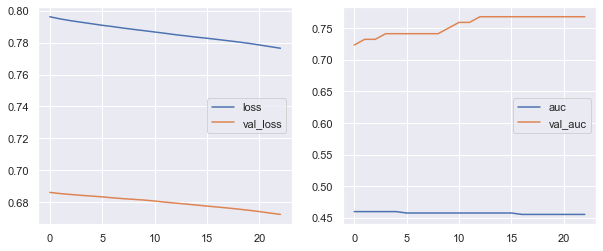

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(history.history["loss"], label="loss")
ax[0].plot(history.history["val_loss"], label="val_loss")
ax[0].legend()

ax[1].plot(history.history["auc"], label="auc")
ax[1].plot(history.history["val_auc"], label="val_auc")
ax[1].legend()

In [22]:
auc_train = roc_auc_dl(model, X_train, y_train)
print("AUC of the train set: %0.5f" % auc_train)

auc_test = roc_auc_dl(model, X_test, y_test)
print("AUC of the test set: %0.5f" % auc_test)

AUC of the train set: 0.45333
AUC of the test set: 0.76786


# B. Regression

In [23]:
Sars2_train = pd.read_csv("Sars2_train.csv")
Sars2_train.head()

,MolID,mol,Class,Model,IC50,EXP,MolecularWeight,ExactMass,HeavyAtoms,Rings,...,MolecularVolume,RotatableBonds,HydrogenBondDonors,HydrogenBondAcceptors,SLogP,SMR,TPSA,Fsp3Carbons,Sp3Carbons,MolecularComplexity
0,Triparanol,CC[NH](CCOc1ccc(cc1)[C@](c1ccc(cc1)C)(Cc1ccc(c...,1,Train,7.05,-7.05,440.02,439.2278,31,3,...,428.55,10,2,3,7.25,133.24,38.36,0.33,9,56
1,Tilorone,CC[NH](CCOc1ccc2c(c1)C(=O)c1c2ccc(c1)OCC[NH](C...,1,Train,4.09,-7.38,414.58,414.2882,30,3,...,417.35,12,2,5,7.15,130.24,53.33,0.48,12,55
2,Tideglusib,O=c1sn(c(=O)n1Cc1ccccc1)c1cccc2c1cccc2,1,Train,1.55,-7.95,334.39,334.0776,24,4,...,275.91,3,0,4,5.06,97.44,44.00,0.05,1,62
3,Tetrandrine,COc1c(OC)cc2c3c1Oc1cc4c(cc1OC)CC[NH]([C@H]4Cc1...,1,Train,3.00,-7.56,626.78,626.3356,46,8,...,580.38,4,2,8,8.26,183.10,77.32,0.37,14,60
4,Shikonin,CC(=CC[C@H](C1=CC(=O)c2c(C1=O)c(O)ccc2O)O)C,0,Train,15.75,-6.58,288.30,288.0998,21,2,...,275.21,3,3,5,2.41,77.08,94.83,0.25,4,38


In [24]:
X_full_train = Sars2_train.drop(["MolID", "mol", "Class", "Model", "IC50", "EXP"], axis="columns")
y_full_train = Sars2_train["EXP"]

X_full_train.shape, y_full_train.shape

((52, 15), (52,))

In [25]:
y_full_train.mean(), y_full_train.std()

(-7.553846153846154, 0.999480558906463)

In [26]:
in_vitro_only = pd.read_csv("in-vitro-only.csv")
X_new = in_vitro_only[X_full_train.columns.to_list()]
X_new.head()

,MolecularWeight,ExactMass,HeavyAtoms,Rings,AromaticRings,MolecularVolume,RotatableBonds,HydrogenBondDonors,HydrogenBondAcceptors,SLogP,SMR,TPSA,Fsp3Carbons,Sp3Carbons,MolecularComplexity
0,502.50,501.2076,34,5,2,462.20,4,1,4,8.07,139.95,40.40,0.54,15,68
1,231.04,229.9579,12,1,1,158.79,2,1,3,1.98,47.75,46.53,0.12,1,37
2,302.71,302.0669,20,2,2,240.24,5,6,7,0.31,73.13,129.83,0.42,5,57
3,158.24,158.1419,11,0,0,175.11,5,0,3,2.85,48.02,32.67,1.00,8,37
4,299.45,299.2249,22,3,1,315.81,2,1,2,4.31,90.85,43.09,0.65,13,45


In [27]:
remover = CollinearColumnRemover(0.95)
remover.fit(X_full_train)
X_full_train = remover.transform(X_full_train)
X_new = remover.transform(X_new)

Number of columns droped due to collinearity: 5
Number of columns droped due to collinearity: 5


In [28]:
scaler = StandardScaler()
scaler.fit(X_full_train)
X_full_train = scaler.transform(X_full_train)

X_new = scaler.transform(X_new)

## B1. Linear Regression

In [29]:
# the result is really bad

X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, 
                                                    test_size=0.33, 
                                                    random_state=530)


lr = LinearRegression()
lr.fit(X_train, y_train)

rmse_train = rmse(lr, X_train, y_train)
print("RMSE of the train set: %0.5f" % rmse_train)
r2_train = r2(lr, X_train, y_train)
print("R2 of the train set: %0.5f" % r2_train)

rmse_test = rmse(lr, X_test, y_test)
print("RMSE of the test set: %0.5f" % rmse_test)
r2_test = r2(lr, X_test, y_test)
print("R2 of the test set: %0.5f" % r2_test)

RMSE of the train set: 0.59210
R2 of the train set: 0.28716
RMSE of the test set: 1.53347
R2 of the test set: -0.56686


## B2. Ridge regression

In [30]:
# the result is really bad

X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, 
                                                    test_size=0.33, 
                                                    random_state=402)


ridge = Ridge()

params = {"alpha": hp.loguniform("alpha", np.log(1e-2), np.log(1e5)),}

num_eval = 50

trials, best_params, best_model = hyperopt_reg(ridge, params, X_train, y_train, num_eval)
print("best_params:", best_params)


rmse_train = rmse(best_model, X_train, y_train)
print("RMSE of the train set: %0.5f" % rmse_train)
r2_train = r2(best_model, X_train, y_train)
print("R2 of the train set: %0.5f" % r2_train)

rmse_test = rmse(best_model, X_test, y_test)
print("RMSE of the test set: %0.5f" % rmse_test)
r2_test = r2(best_model, X_test, y_test)
print("R2 of the test set: %0.5f" % r2_test)

100%|██████████| 50/50 [00:00<00:00, 69.16trial/s, best loss: -1.3742849653317974]
Time elapsed: 0.72911 s
best_params: {'alpha': 0.01049417522683663}
RMSE of the train set: 0.23053
R2 of the train set: 0.26989
RMSE of the test set: 6.54972
R2 of the test set: -0.63783
